In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense

import keras
from keras import losses
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [3]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [4]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(10, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 10 images
satImage_089.png
Loading 10 images
satImage_089.png


Image size = 400,400


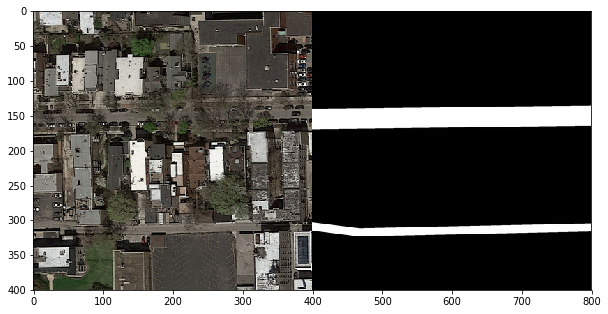

In [5]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [6]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
#img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
#gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [7]:
# Given an input image 
def image_to_inputs(img, gt):
    rows, cols, _ = img.shape
    
    patches = [
        (
            img[i-2*patch_size:i+3*patch_size, j-2*patch_size:j+3*patch_size, :],
            gt[i:i+patch_size, j:j+patch_size]
        )
        for i in range(2*patch_size, rows - 3*patch_size, patch_size)
        for j in range(2*patch_size, cols - 3*patch_size, patch_size)
    ]

    return patches

In [8]:
all_inputs = [inputs for i in range(n) for inputs, _ in image_to_inputs(imgs[i], gt_imgs[i])]
all_gt = [np.mean(gt) for i in range(n) for _, gt in image_to_inputs(imgs[i], gt_imgs[i])]

In [9]:
#Y = np.mean(np.asarray(gt_patches), axis=(2,3))
X = np.asarray(all_inputs)
y = np.asarray(all_gt)

In [10]:
X.shape

(4000, 80, 80, 3)

In [11]:
def train_test_split(X, y, test_ratio=0.8, seed=42):
    n = len(X)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    limit = int(test_ratio * n)
    X_train, y_train = X[idxs[:limit]], y[idxs[:limit]]
    X_test, y_test = X[idxs[limit:]], y[idxs[limit:]]
    return X_train, X_test, y_train, y_test

In [12]:
batch_size = 128
#num_classes = 2
epochs = 5

# the data, shuffled and split between train and test sets
x_train, x_test, y_train, y_test  = train_test_split(X, y, 0.8)

In [13]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, 5*patch_size, 5*patch_size)
    x_test = x_test.reshape(x_test.shape[0], 3, 5*patch_size, 5*patch_size)
    input_shape = (3, img_rows, img_cols)
else:
    # We should be here
    x_train = x_train.reshape(x_train.shape[0], 5*patch_size, 5*patch_size, 3)
    x_test = x_test.reshape(x_test.shape[0], 5*patch_size, 5*patch_size, 3)
    input_shape = (5*patch_size, 5*patch_size, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Already scaled
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (3200, 80, 80, 3)
3200 train samples
800 test samples


In [16]:
# Convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(batch_size, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(batch_size, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))
#model.add(Dense(patch_size * patch_size, activation='softmax'))
#model.add(Reshape((patch_size, patch_size)))

model.compile(loss=losses.mean_squared_error,
              optimizer=keras.optimizers.SGD(), #keras.optimizers.Adadelta(),
              metrics=['mse'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test MSE:', score[1])

Train on 3200 samples, validate on 800 samples
Epoch 1/5
 384/3200 [==>...........................] - ETA: 498s - loss: 0.7830 - mean_squared_error: 0.7830

KeyboardInterrupt: 

In [160]:
np.sum(model.predict(np.array([x_train[5]])))

1.0

In [ ]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [ ]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [ ]:
X.shape

In [ ]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

In [ ]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

In [ ]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [ ]:
X.shape

In [ ]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)